# Objetivos

1. Descrever a série temporal de acordo com as suas componentes e propriedades.
Desde a tendência, sazonalidade, heterocedastidade, entre outros.

2. Descrever a estrutura ARIMA que melhor se adequa aos dados

3. Avaliar diferentes métodos de aprendizagem máquina com validação cruzada.

4. Analisar os resultados obtidos no ponto 3. Descrever o impacto dos seguintes aspetos no desempenho preditivo: a) diferentes horizontes de previsão, b) desempenho nos valores extremos, diferentes algoritmos de aprendizagem máquina

# Imports

In [11]:
#%pip install sktime
#%pip install pmdarima
#%pip install lightgbm

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs, nsdiffs
from lightgbm import LGBMRegressor
from statsmodels.graphics.tsaplots import plot_pacf


%matplotlib inline

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


In [14]:
# Montar o Google Drive

#from google.colab import drive
#import sys

#drive.mount('/content/drive')

In [15]:
# Adicionar o caminho da pasta src ao sys.path

#sys.path.append('/content/drive/MyDrive/src')
#from error import MASE
from src.error import MASE

In [16]:
# https://github.com/vcerqueira/energy_load_data
#data = pd.read_csv('/content/energy_load_pt.csv')
data = pd.read_csv('assets/energy_load_pt.csv')
# dimensão dos dados
data.shape

(13104, 2)

In [17]:
data.head()

,datetime,load
0,2020-11-17 08:00:00,5159.0
1,2020-11-17 09:00:00,4985.0
2,2020-11-17 10:00:00,4717.0
3,2020-11-17 11:00:00,4356.0
4,2020-11-17 12:00:00,4086.0


# Initial Plots

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


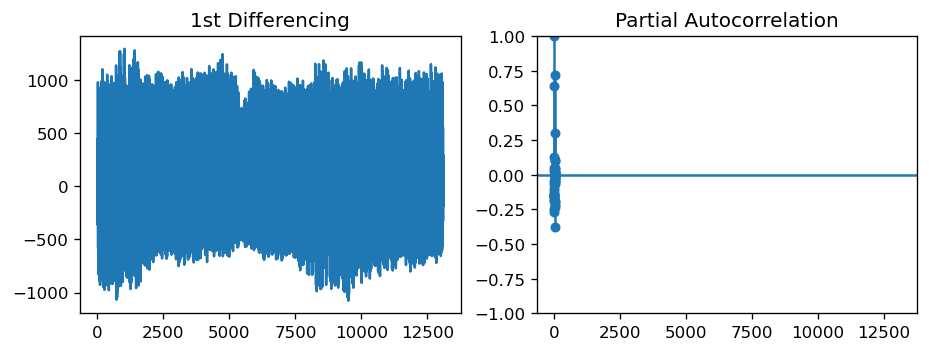

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.load.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.load.diff().dropna(), ax=axes[1])

plt.show()

<AxesSubplot:xlabel='datetime'>

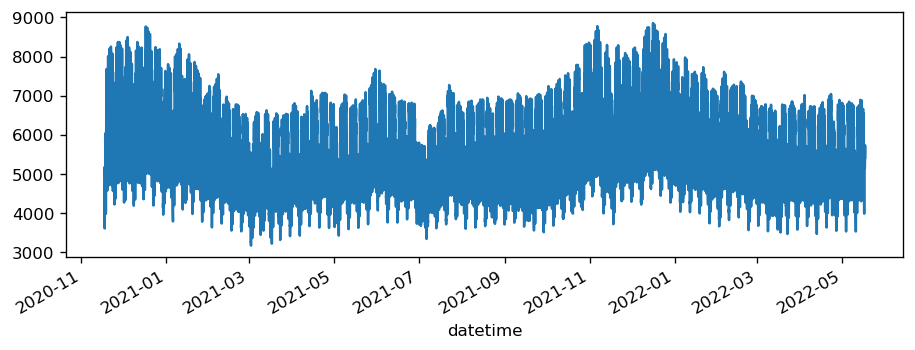

In [19]:
series = pd.Series(data['load'])
series.index = pd.to_datetime(data['datetime'])
series.plot()

<AxesSubplot:>

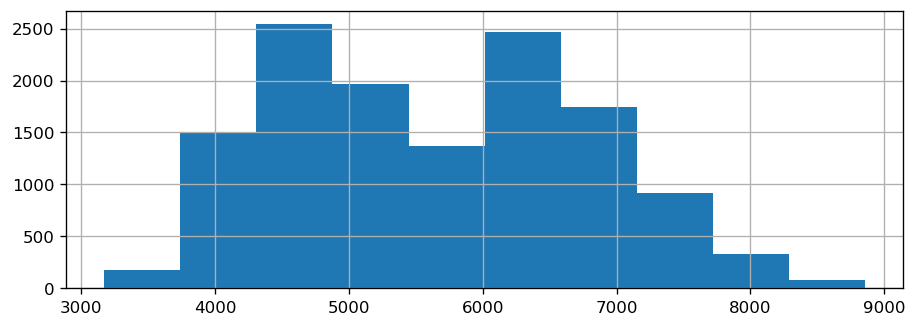

In [20]:
series.hist()

<AxesSubplot:xlabel='datetime'>

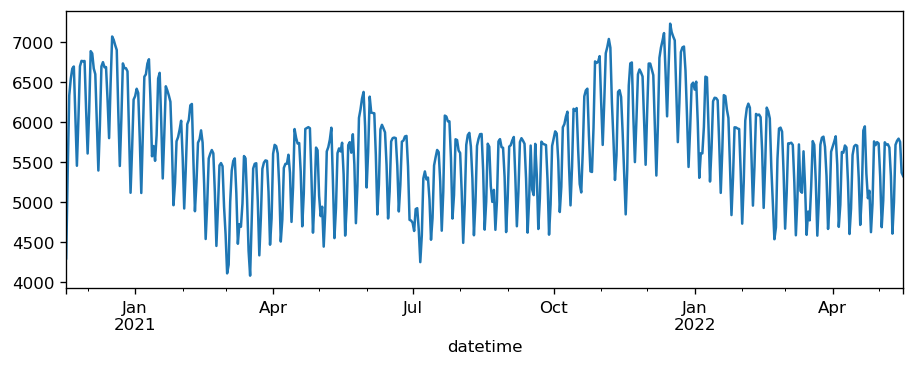

In [21]:
series.resample('D').mean().plot()

In [22]:
series.dtypes

dtype('float64')

Tratando valores NANs

In [112]:
print(series.isnull().sum())

0


In [24]:
# Encontrar os índices dos valores NaN
indices_nans = np.isnan(series)

# Calcular a média dos valores não-NaN
media = np.nanmean(series)

# Substituir os valores NaN pela média
series[indices_nans] = media

# Mostrar o array após a substituição
print("\nArray após substituir NaNs pela média:")
print(series)


Array após substituir NaNs pela média:
datetime
2020-11-17 08:00:00    5159.0
2020-11-17 09:00:00    4985.0
2020-11-17 10:00:00    4717.0
2020-11-17 11:00:00    4356.0
2020-11-17 12:00:00    4086.0
                        ...  
2022-05-17 04:00:00    5190.0
2022-05-17 05:00:00    5297.0
2022-05-17 06:00:00    5441.0
2022-05-17 07:00:00    5735.0
2022-05-17 08:00:00    5418.0
Name: load, Length: 13104, dtype: float64


In [25]:
df = pd.DataFrame(series)
df

,load
datetime,
2020-11-17 08:00:00,5159.0
2020-11-17 09:00:00,4985.0
2020-11-17 10:00:00,4717.0
2020-11-17 11:00:00,4356.0
2020-11-17 12:00:00,4086.0
...,...
2022-05-17 04:00:00,5190.0
2022-05-17 05:00:00,5297.0
2022-05-17 06:00:00,5441.0


# PMD Arima

In [26]:
%pip install ARIMA

ERROR: Could not find a version that satisfies the requirement ARIMA (from versions: none)
ERROR: No matching distribution found for ARIMA
Note: you may need to restart the kernel to use updated packages.


In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
# 1,1,2 ARIMA Model
model = ARIMA(df.load, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                13104
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -92375.382
Date:                Sun, 24 Mar 2024   AIC                         184758.765
Time:                        17:30:21   BIC                         184788.687
Sample:                             0   HQIC                        184768.759
                              - 13104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5028      0.041     12.269      0.000       0.422       0.583
ma.L1          0.2213      0.042      5.288      0.000       0.139       0.303
ma.L2          0.0133      0.029      0.456      0.6

In [29]:
# 1,1,1 ARIMA Model
model = ARIMA(df.load, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                13104
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -92375.752
Date:                Sun, 24 Mar 2024   AIC                         184757.503
Time:                        17:30:24   BIC                         184779.945
Sample:                             0   HQIC                        184764.999
                              - 13104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5130      0.015     33.254      0.000       0.483       0.543
ma.L1          0.2126      0.017     12.304      0.000       0.179       0.246
sigma2      7.803e+04    747.448    104.402      0.0

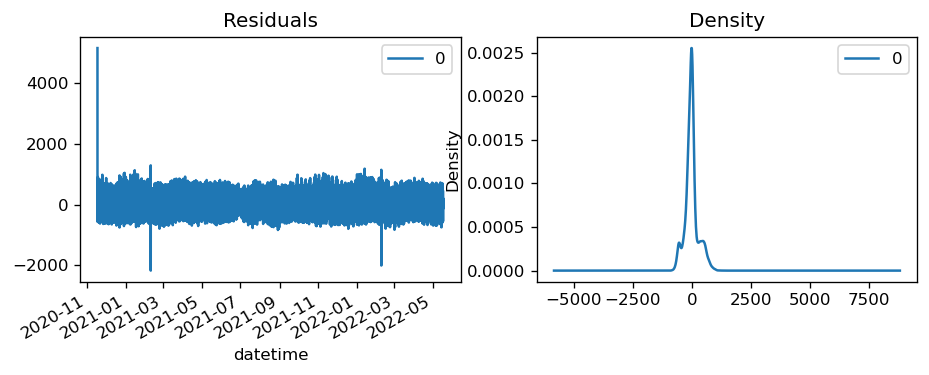

In [30]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


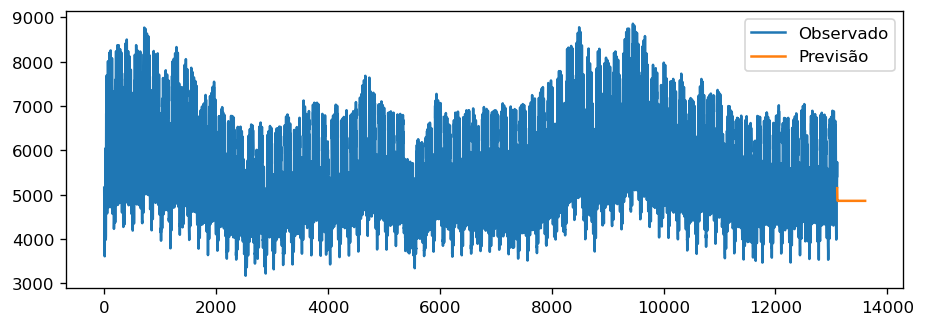

In [31]:
serie = pd.Series(series)

# Ajustar o modelo ARIMA
model = ARIMA(serie, order=(1,1,1))
results = model.fit()

# Fazer previsões
forecast = results.forecast(steps=500)

# Plotar resultados
plt.plot(np.arange(len(serie)), serie, label='Observado')
plt.plot(np.arange(len(serie), len(serie)+len(forecast)), forecast, label='Previsão')
plt.legend()
plt.show()

é uma função projetada para selecionar automaticamente o melhor modelo ARIMA (AutoRegressive Integrated Moving Average) para uma série temporal, usando heurísticas inteligentes e busca exaustiva.

pm.auto_arima é uma função conveniente e poderosa para automatizar o processo de seleção de modelos ARIMA para séries temporais em Python, permitindo aos usuários evitar o trabalho manual de encontrar o modelo mais adequado e otimizando a precisão das previsões.

In [33]:
#from statsmodels.tsa.stattools import acf

#train = df.load[:85]
#test = df.load[85:]
#train = df.load[:10483]
#test = df.load[10483:]

In [98]:
from sklearn.model_selection import train_test_split

# Supondo que 'dados' seja o seu DataFrame ou array
# Dividir os dados em 80% de treinamento e 20% de teste
train, test = train_test_split(series, test_size=0.2, random_state=42)

# Exibindo o tamanho dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(train))
print("Tamanho do conjunto de teste:", len(test))

Tamanho do conjunto de treinamento: 10483
Tamanho do conjunto de teste: 2621


In [99]:
print(train.isnull().sum()) 

0


In [100]:
print(test.isna().sum())

0


In [101]:
from pmdarima.arima import auto_arima
model = auto_arima(train, seasonal=False)

In [102]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10483
Model:               SARIMAX(2, 0, 0)   Log Likelihood              -88683.760
Date:                Sun, 24 Mar 2024   AIC                         177375.520
Time:                        18:27:28   BIC                         177404.550
Sample:                             0   HQIC                        177385.324
                              - 10483                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5785.3953     78.096     74.081      0.000    5632.330    5938.460
ar.L1          0.0094      0.010      0.965      0.334      -0.010       0.029
ar.L2         -0.0330      0.010     -3.397      0.001      -0.052      -0.014
sigma2      1.305e+06   2.51e+04     52.033      0.000    1.26e+06    1.35e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               443.78
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             0.20
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

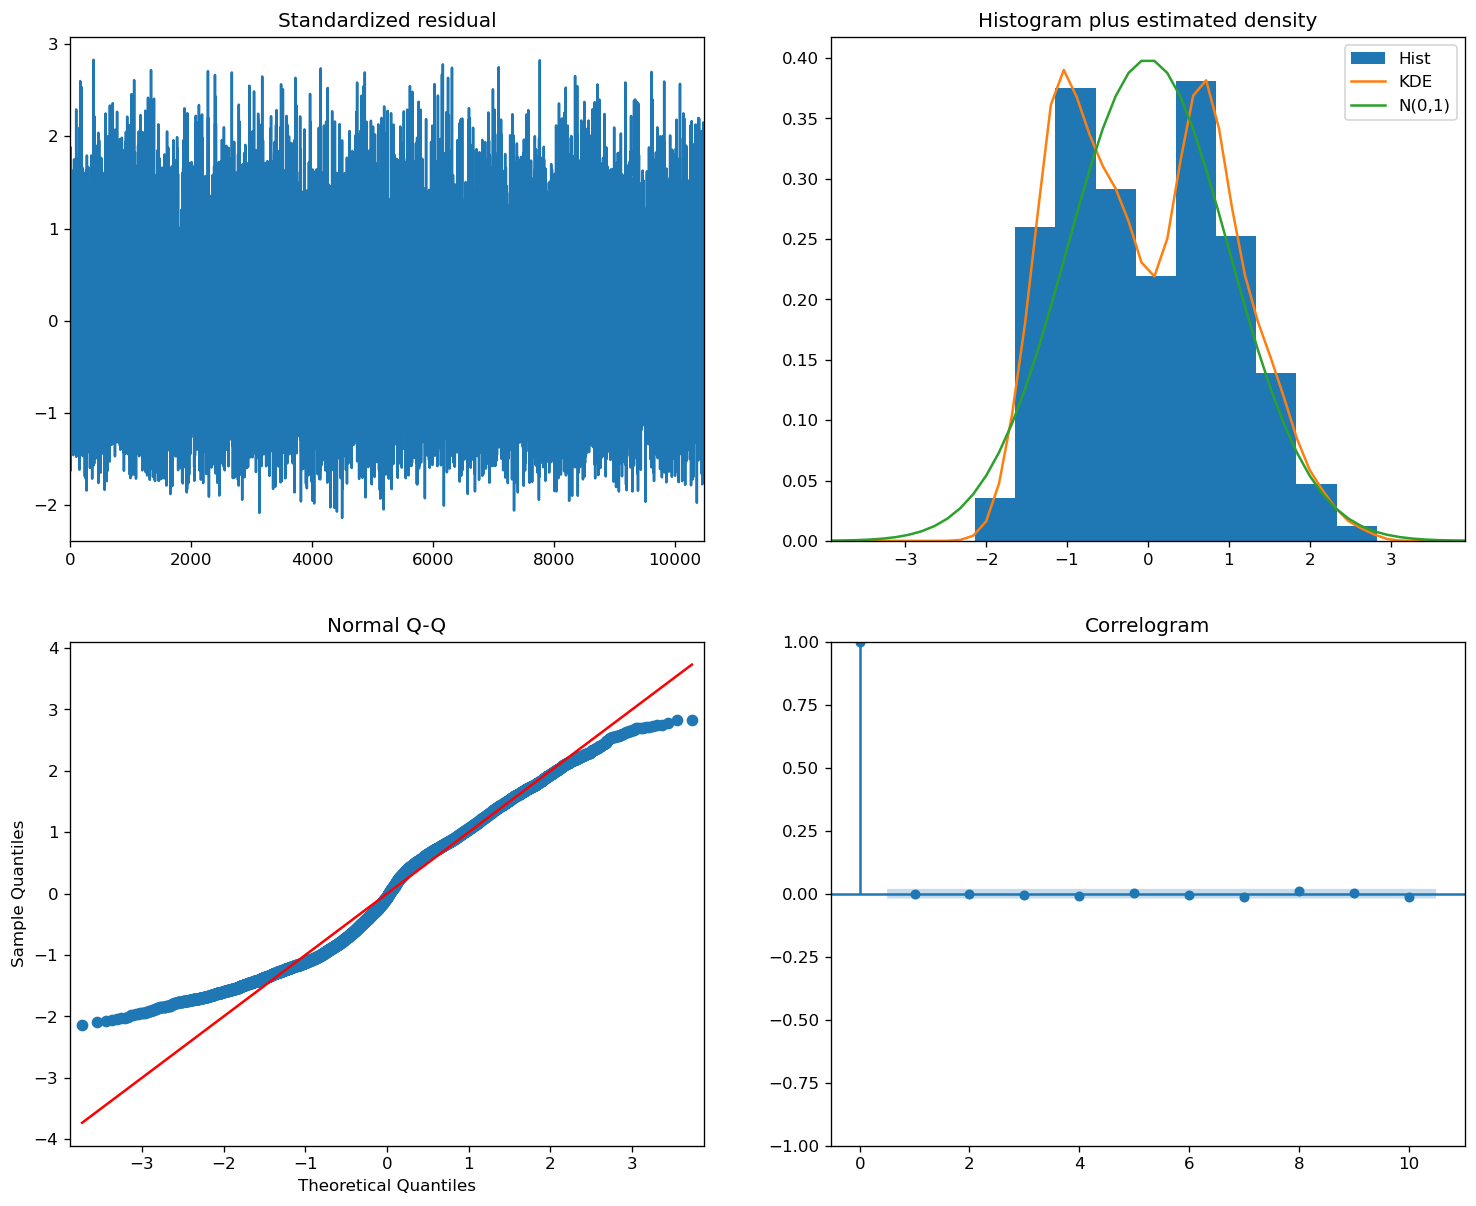

In [104]:
plot=model.plot_diagnostics(figsize=(15, 12))

In [124]:
len(test)

2621

In [119]:
print(forecasts.isnull().sum()) 

0


In [103]:
model.fit(train)

ARIMA(order=(2, 0, 0), scoring_args={}, suppress_warnings=True)

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dcm/anac

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


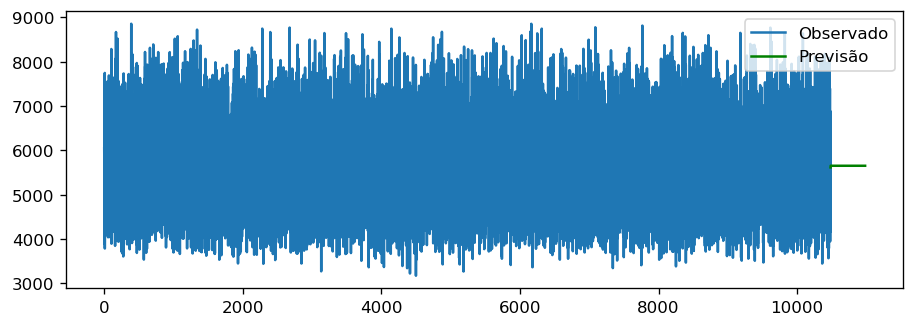

In [130]:
serie = pd.Series(train)

# Ajustar o modelo ARIMA
model = ARIMA(train, order=(2,0,0))
results = model.fit()

# Fazer previsões
forecast = results.forecast(steps=500)

# Plotar resultados
plt.plot(np.arange(len(serie)), serie, label='Observado')
plt.plot(np.arange(len(serie), len(serie)+len(forecast)), forecast, color='green', label='Previsão')
plt.legend()
plt.show()

In [131]:
err = MASE(train, test, forecasts)
err

nan

# nsdiffs kpss, adf, ocsb, ch  test

In [281]:
ndiffs(series, test='kpss')

1

O teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin) é um teste estatístico utilizado para determinar se uma série temporal é estacionária em torno de uma tendência determinística.

Hipótese alternativa (H1): A série temporal não é estacionária em torno de uma tendência determinística (a série é estacionária em torno de uma tendência estocástica ou a série é não estacionária).

O resultado do teste KPSS geralmente é interpretado comparando-se o valor-p (p-value) obtido com um nível de significância pré-determinado (por exemplo, 0,05). Se o valor-p for menor que o nível de significância escolhido, rejeitamos a hipótese nula, o que sugere que a série não é estacionária em torno de uma tendência determinística. Se o valor-p for maior que o nível de significância, não podemos rejeitar a hipótese nula, o que sugere que a série pode ser estacionária em torno de uma tendência determinística.

O teste KPSS é útil especialmente quando há dúvidas sobre a presença de tendência em uma série temporal e é complementar ao teste ADF, fornecendo uma visão mais abrangente da estacionariedade da série.

In [282]:
# augmented dickey-fuller
# O teste ADF é comumente usado para testar a estacionariedade em uma série temporal
ndiffs(series, test='adf')

0

In [283]:
# testes para sazonalidade
nsdiffs(series, test='ocsb', m=4)

0

In [284]:
# Assim como o teste ADF, o teste CH é usado para verificar a estacionariedade em uma série temporal
nsdiffs(series, test='ch', m=4)

1

<AxesSubplot:xlabel='datetime'>

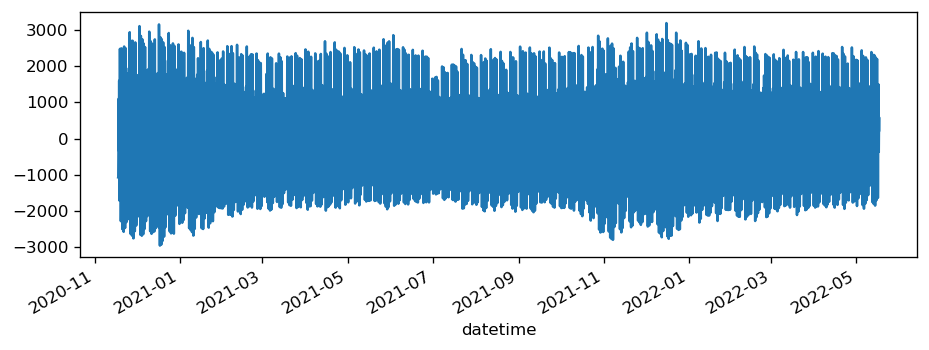

In [285]:
# residuos
series.diff(periods=4).plot()

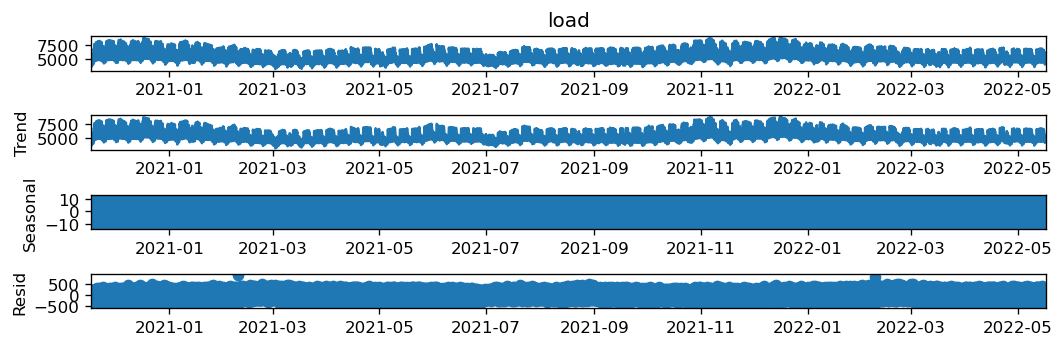

In [286]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(series,
                            model='additive',
                            period=4)

plt = result.plot()

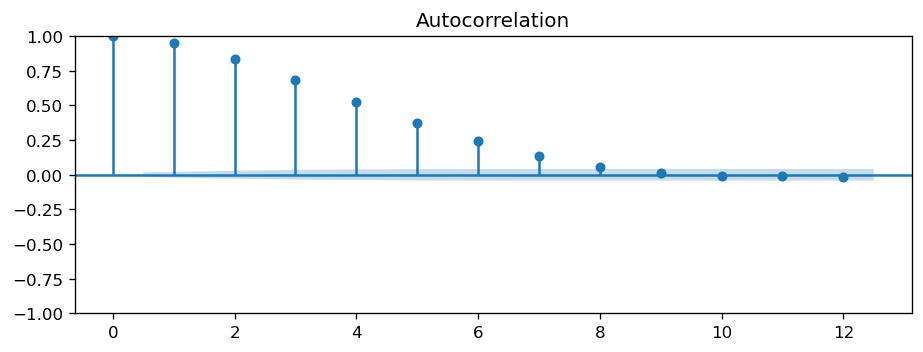

In [287]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt = plot_acf(series, lags=12)

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


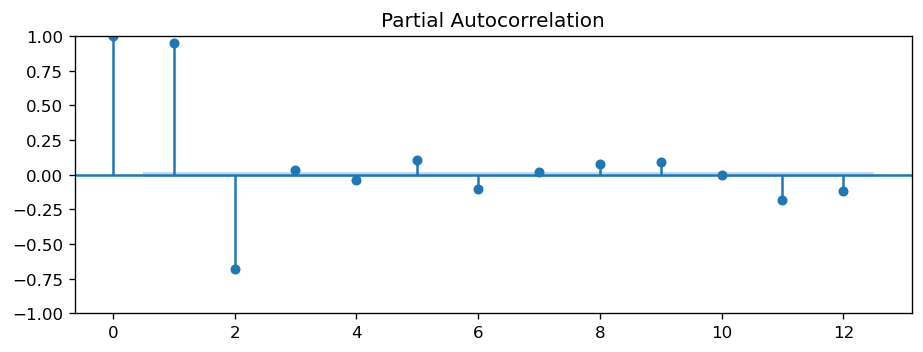

In [288]:
plt = plot_pacf(series, lags=12)

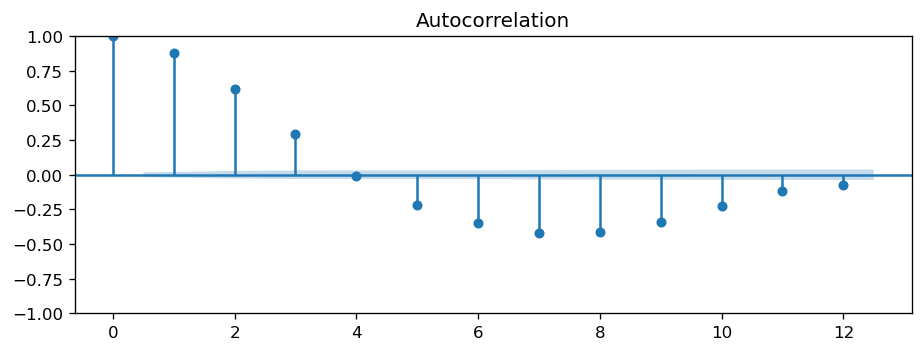

In [289]:
plt = plot_acf(series.diff(periods=4)[4:], lags=12)

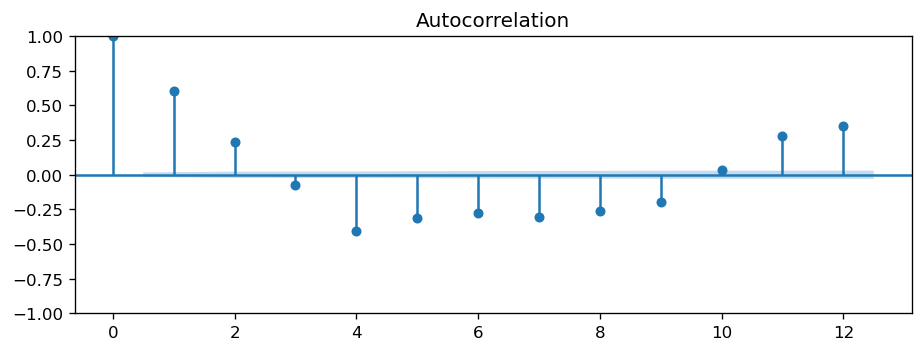

In [290]:
plt = plot_acf(series.diff().diff(periods=4)[5:], lags=12)

*A nálise da autocorrelação: Calculando e plotando a função de autocorrelação (ACF) da série temporal. Se não houver picos significativos nos lags (atrasos) da autocorrelação, isso sugere que não há padrões de sazonalidade na série.
* Se o teste KPSS indicar que a série é estacionária em torno de uma tendência determinística (KPSS = 1), geralmente não é necessário remover a tendência.
* A remoção da sazonalidade depende da presença e importância da sazonalidade na série, bem como dos objetivos da análise. Se a sazonalidade estiver presente e for significativa, pode ser aconselhável remover a sazonalidade antes de prosseguir com a modelagem ou análise dos dados.

* Assim, não há necessidade de remover a tendência, pois a série já é estacionária em torno dela.

Heterocedastidade

In [146]:
from src.heteroskedasticity import het_tests
#from heteroskedasticity import het_tests


p_value = het_tests(series, test='white')
# p_value = het_tests(series, test='breuschpagan')

p_value

3.152845340045858e-17

No caso do p-value ser 3.152845340045858×10−17, isso significa que a probabilidade de observar um resultado tão extremo ou mais extremo do que o observado sob a hipótese nula é extremamente baixa. Em muitos contextos, esse valor seria considerado muito menor do que qualquer nível de significância comumente usado (0,05, por exemplo), então normalmente rejeitaríamos a hipótese nula com um p-value tão baixo, a menos que haja algum problema com os dados ou o teste.

In [292]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# box-cox
transformed_data, best_lambda = boxcox(series)

print(transformed_data[:5])
print(series.values[:5])
print(best_lambda)

[30.87870628 30.57489473 30.09112833 29.40602872 28.86544861]
[5159. 4985. 4717. 4356. 4086.]
0.25564394296205334


A transformação de Box-Cox é uma técnica estatística usada para estabilizar a variância e tornar os dados mais próximos da normalidade. Ela é especialmente útil quando os dados têm uma distribuição assimétrica ou heterocedasticidade.

<AxesSubplot:>

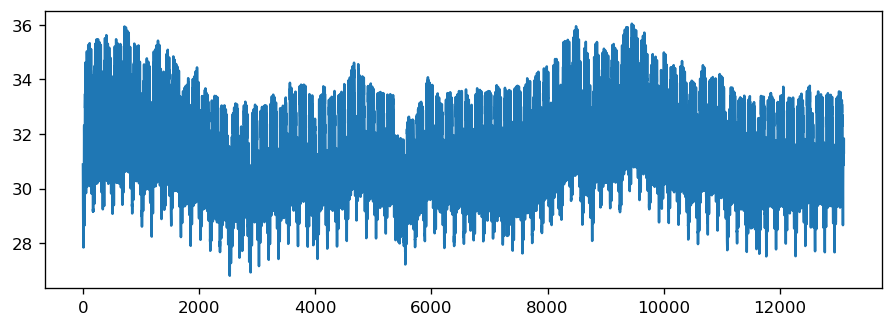

In [293]:
pd.Series(transformed_data).plot()

<AxesSubplot:xlabel='datetime'>

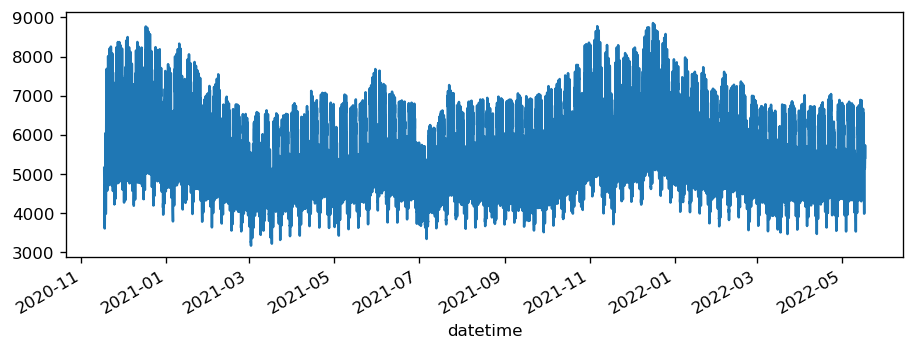

In [294]:
series.plot()

In [295]:
# revertendo
original_series = inv_boxcox(transformed_data, best_lambda)

original_series[:5]

array([5159., 4985., 4717., 4356., 4086.])

In [296]:
all(np.isclose(original_series, series.values))

True

# Train test split / UnivariateTDE

In [147]:
from src.tde import UnivariateTDE
#from tde import UnivariateTDE

# vários pontos no futuro

UnivariateTDE(data=series, k=5, horizon=1)

,t-4,t-3,t-2,t-1,t-0,t+1
0,5159.0,4985.0,4717.0,4356.0,4086.0,3917.0
1,4985.0,4717.0,4356.0,4086.0,3917.0,3839.0
2,4717.0,4356.0,4086.0,3917.0,3839.0,3811.0
3,4356.0,4086.0,3917.0,3839.0,3811.0,3634.0
4,4086.0,3917.0,3839.0,3811.0,3634.0,3610.0
...,...,...,...,...,...,...
13094,5335.0,5295.0,5227.0,5158.0,5147.0,5190.0
13095,5295.0,5227.0,5158.0,5147.0,5190.0,5297.0
13096,5227.0,5158.0,5147.0,5190.0,5297.0,5441.0
13097,5158.0,5147.0,5190.0,5297.0,5441.0,5735.0


In [148]:
series_df = UnivariateTDE(data=series, k=5, horizon=1)
series_df.head()

,t-4,t-3,t-2,t-1,t-0,t+1
0,5159.0,4985.0,4717.0,4356.0,4086.0,3917.0
1,4985.0,4717.0,4356.0,4086.0,3917.0,3839.0
2,4717.0,4356.0,4086.0,3917.0,3839.0,3811.0
3,4356.0,4086.0,3917.0,3839.0,3811.0,3634.0
4,4086.0,3917.0,3839.0,3811.0,3634.0,3610.0


In [149]:
# separando as variáveis explicativas
X = series_df.drop('t+1', axis=1)
y = series_df['t+1']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

RadomForest Regressor

In [150]:
# treinando uma Random Forest
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [151]:
# previsoes
forecasts = model.predict(X_test)
forecasts[:10]

array([4848.37, 5420.31, 6093.83, 7164.48, 7492.14, 7590.67, 7490.34,
       7086.05, 7155.  , 7202.87])

In [152]:
# computing the error
from src.error import MASE
#from error import MASE

MASE(y_train, y_test, forecasts)

0.4329484466266353

<AxesSubplot:title={'center':'Forecasting with RF'}>

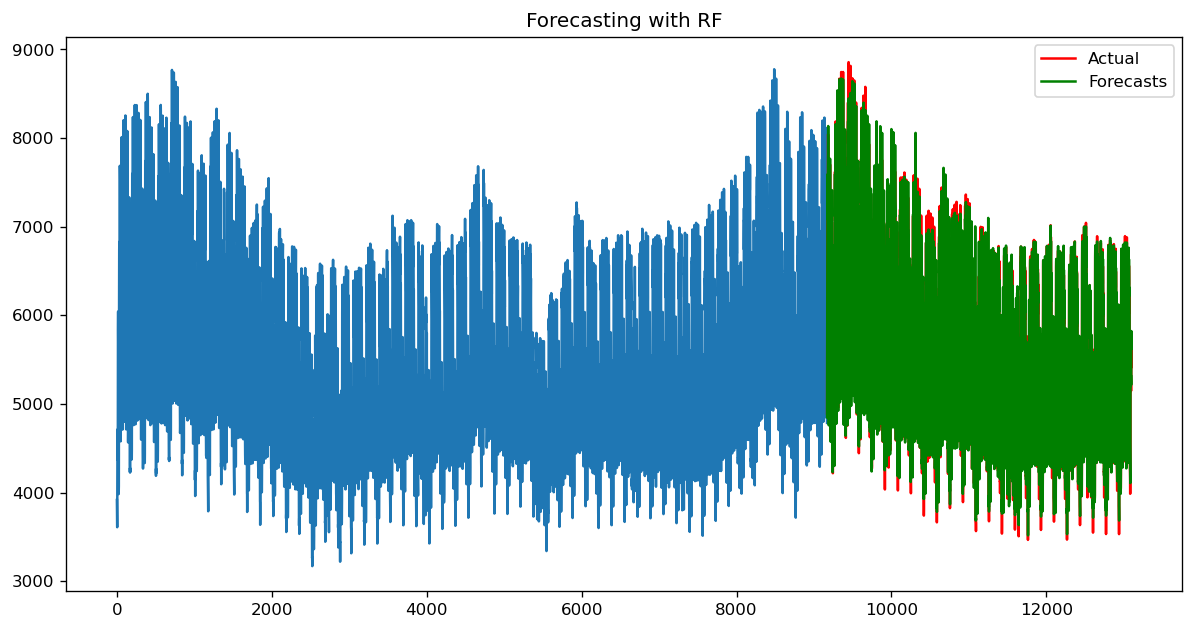

In [153]:
y_test = y_test.rename('Actual')
forecasts = pd.Series(forecasts, index=y_test.index).rename('Forecasts')
ax = y_train.plot()
ax = y_test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with RF')
forecasts.plot(legend=True, color='green')

In [154]:
ridge = Ridge()
lasso = Lasso()
linear_reg = LinearRegression()
rf = RandomForestRegressor()
tree = DecisionTreeRegressor()
lgbm = LGBMRegressor()

Modelos: Ridge, lasso, linear_reg, rf, tree, lgbm

In [155]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
linear_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
tree.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9169, number of used features: 5
[LightGBM] [Info] Start training from score 5632.701521


LGBMRegressor()

In [156]:
models = [ridge, lasso, linear_reg, rf, tree, lgbm]
colors = ['yellow','orange','green','grey','black','purple']
forecasts = []
for j,m in enumerate(models):
    print(j)
    pred = m.predict(X_test)
    pred = pd.Series(pred, index=y_test.index).rename(f'Forecast {j}')
    forecasts.append(pred)

0
1
2
3
4
5


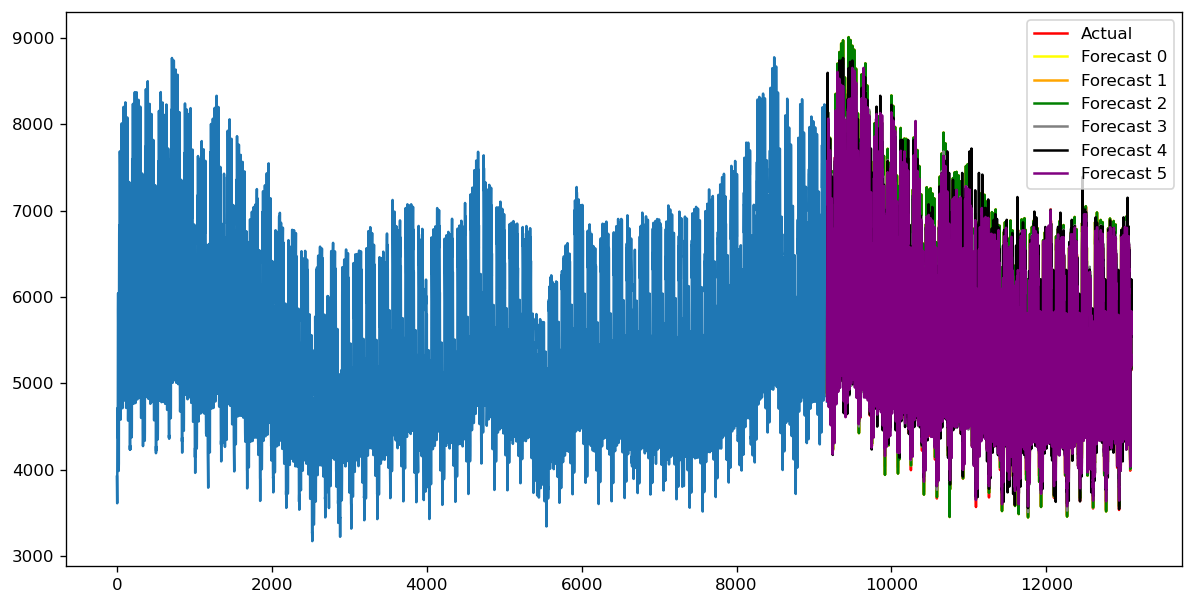

In [157]:
ax = y_train.plot()
ax = y_test.plot(legend=True,color='red', figsize=(12,6))
for j, pred in enumerate(forecasts):
    pred.plot(legend=True, color=colors[j])

In [158]:
for pred in forecasts:
    print(MASE(y_train, y_test, pred))

0.6964937645065193
0.6964993128926821
0.6964937641174426
0.4367782180132703
0.5385209763062151
0.47853121177160807


O modelo que apresenta menor erro, ou melhor desempenho é o RF

In [159]:
ridge.fit(X_train[1:], y_train.diff()[1:])
lasso.fit(X_train[1:], y_train.diff()[1:])
linear_reg.fit(X_train[1:], y_train.diff()[1:])
rf.fit(X_train[1:], y_train.diff()[1:])
tree.fit(X_train[1:], y_train.diff()[1:])
lgbm.fit(X_train[1:], y_train.diff()[1:])

/home/dcm/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+05, tolerance: 1.216e+05
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 9168, number of used features: 5
[LightGBM] [Info] Start training from score 0.094895


LGBMRegressor()

In [160]:
models = [ridge, lasso, linear_reg, rf, tree, lgbm]
for m in models:
    pred = m.predict(X_test)
    print(MASE(y_train.diff()[1:], y_test.diff()[1:], pred[1:]))

0.8387672539283312
0.8387738365590107
0.8387672535725582
0.49304656611330555
0.6214526192284778
0.5633621798419459


Em 'y_train.diff()[1:]' e 'y_test.diff()[1:]' estamos calculando a diferença entre elementos consecutivos de y_train e y_test, respectivamente, começando do segundo elemento (índice 1) até o final.

In [161]:
# same process but with differenced data
train_df = UnivariateTDE(data=series.diff(), k=5, horizon=1)
print(train_df)

X_train, y_train = train_df.drop('t+1', axis=1), train_df['t+1']

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train.values, y_train)

         t-4    t-3    t-2    t-1    t-0    t+1
0     -174.0 -268.0 -361.0 -270.0 -169.0  -78.0
1     -268.0 -361.0 -270.0 -169.0  -78.0  -28.0
2     -361.0 -270.0 -169.0  -78.0  -28.0 -177.0
3     -270.0 -169.0  -78.0  -28.0 -177.0  -24.0
4     -169.0  -78.0  -28.0 -177.0  -24.0  326.0
...      ...    ...    ...    ...    ...    ...
13093 -192.0  -40.0  -68.0  -69.0  -11.0   43.0
13094  -40.0  -68.0  -69.0  -11.0   43.0  107.0
13095  -68.0  -69.0  -11.0   43.0  107.0  144.0
13096  -69.0  -11.0   43.0  107.0  144.0  294.0
13097  -11.0   43.0  107.0  144.0  294.0 -317.0

[13098 rows x 6 columns]


RandomForestRegressor()

In [162]:
forecast = model.predict(X_test)
print(forecast)

[79.76 79.76 79.76 ... 79.76 79.76 79.76]


/home/dcm/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


# Validação Cruzada

In [163]:
cv = TimeSeriesSplit(n_splits=5)

cv_err = []
for tr_idx, ts_idx in cv.split(X_train, y_train):
    print('Training indices:')
    print(tr_idx[-5:])
    X_tr = X_train.values[tr_idx]
    y_tr = y_train.values[tr_idx]

    X_vl = X_train.values[ts_idx]
    y_vl = y_train.values[ts_idx]

    print('Training the model')
    model = Ridge()

    model.fit(X_tr, y_tr)
    print('Making predictions')
    pred = model.predict(X_vl)

    print('Computing error')
    err = mean_absolute_error(y_vl, pred)
    cv_err.append(err)


print(cv_err)

Training indices:
[2178 2179 2180 2181 2182]
Training the model
Making predictions
Computing error
Training indices:
[4361 4362 4363 4364 4365]
Training the model
Making predictions
Computing error
Training indices:
[6544 6545 6546 6547 6548]
Training the model
Making predictions
Computing error
Training indices:
[8727 8728 8729 8730 8731]
Training the model
Making predictions
Computing error
Training indices:
[10910 10911 10912 10913 10914]
Training the model
Making predictions
Computing error
[180.13122317471237, 169.32474045339694, 193.54870818756126, 214.97238220534103, 182.94011668656205]


In [164]:
# erro estimado em validação cruzada
print(f'Average error is: {np.mean(cv_err)}')

Average error is: 188.18343414151474


In [165]:
# erro que obtemos no teste
model = Ridge()
model.fit(X_train, y_train)
pred_test = model.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test)
print(f'Test error is: {err_test}')

Test error is: 2941.380048745022


In [166]:
model_list = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=10),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
}

from sklearn.model_selection import cross_val_score

In [167]:
err_by_method = {}
for method in model_list:
    print(f'Running model: {method}')
    cv_error = cross_val_score(model_list[method],
                               X_train,
                               y_train,
                               cv=cv,
                               scoring='neg_mean_absolute_error')

    err_by_method[method] = -np.mean(cv_error)

Running model: Ridge
Running model: Lasso
Running model: RandomForestRegressor


Running model: DecisionTreeRegressor
Running model: KNeighborsRegressor


* Comparação entre os diferentes modelos

<AxesSubplot:>

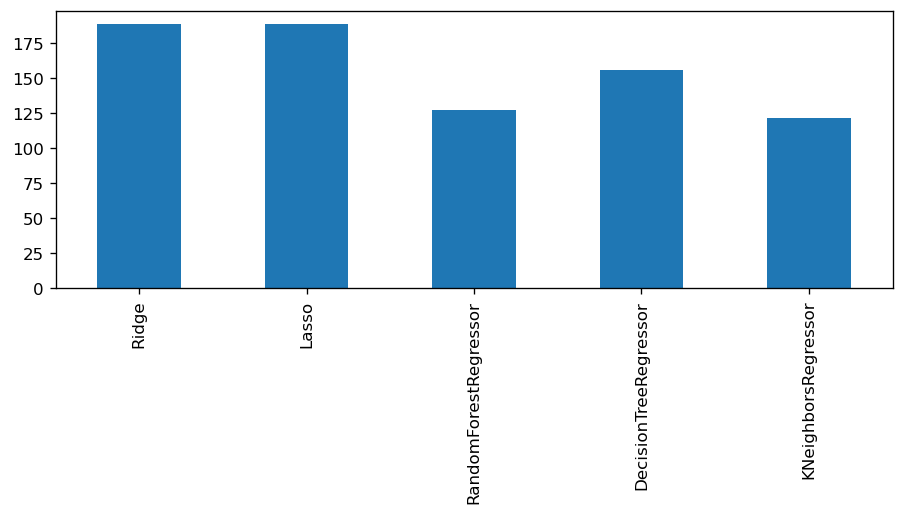

In [168]:
pd.Series(err_by_method).plot.bar()

In [169]:
from pprint import pprint
pprint(err_by_method)

{'DecisionTreeRegressor': 155.9245545626608,
 'KNeighborsRegressor': 121.36018360608784,
 'Lasso': 188.1836646770107,
 'RandomForestRegressor': 127.18803112378139,
 'Ridge': 188.18343414151477}


In [170]:
from sklearn.model_selection import GridSearchCV

parameters = {'weights': ['uniform', 'distance'],
              'n_neighbors': [1, 5, 10]}

In [171]:
model = KNeighborsRegressor()
cv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           cv=cv,
                           refit=True)

In [172]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 5, 10],
                         'weights': ['uniform', 'distance']})

In [173]:
grid_search.best_estimator_

KNeighborsRegressor(n_neighbors=10, weights='distance')

In [174]:
pred_test_best = grid_search.predict(X_test)
err_test = mean_absolute_error(y_test, pred_test_best)
print(f'Test error is: {err_test}')

Test error is: 5590.493991389738


Entre os diferentes métodos de aprendizagem máquina com validação cruzada, 'KNeighborsRegressor' se apresentou melhor.

In [196]:
#from statsmodels.tsa.stattools import acf

train = df.load[:85]
test = df.load[85:]

In [197]:
# auto arima
import pmdarima as pm

model = pm.auto_arima(train, m=4, trace=True, suppress_warnings=True)
?auto_arima

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1249.038, Time=0.19 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1195.752, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1205.808, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1247.393, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1194.703, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=1195.275, Time=0.31 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=1195.933, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=1191.799, Time=0.18 sec
 ARIMA(2,1,0)(1,0,0)[4] intercept   : AIC=1193.571, Time=0.46 sec
 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=1193.469, Time=0.37 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=1194.248, Time=0.91 sec
 ARIMA(3,1,0)(0,0,0)[4] intercept   : AIC=1193.356, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=1

Signature:
auto_arima(
    y,
    X=None,
    start_p=2,
    d=None,
    start_q=2,
    max_p=5,
    max_d=2,
    max_q=5,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=2,
    max_D=1,
    max_Q=2,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method='lbfgs',
    maxiter=50,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action='trace',
    trace=False,
    random=False,
    random_state=None,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring='mse',
    scoring_args=None,
    with_intercept='auto',
    sarimax_kwargs=None,
    **fit_args,
)
Docstring:
Automatically discover the optimal order for an ARIMA model.

The auto-ARIMA process seeks to identify the most optimal
parameters for an ``ARIMA`` model, settling on a

In [198]:
AR = pm.ARIMA(order=(1,0,0))
MA = pm.ARIMA(order=(0,0,1))

AR.fit(train)

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


ARIMA(order=(1, 0, 0))

In [199]:
AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -630.185
Date:                Sun, 24 Mar 2024   AIC                           1266.370
Time:                        19:13:42   BIC                           1273.698
Sample:                    11-17-2020   HQIC                          1269.317
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    254.8896    264.675      0.963      0.336    -263.865     773.644
ar.L1          0.9565      0.043     22.123      0.000       0.872       1.041
sigma2      1.575e+05   2.71e+04      5.807      0.000    1.04e+05    2.11e+05
===================================================================================
Ljung-Box (L1) (Q):                  45.63   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.00   Prob(JB):                         0.28
Heteroskedasticity (H):               1.89   Skew:                             0.43
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

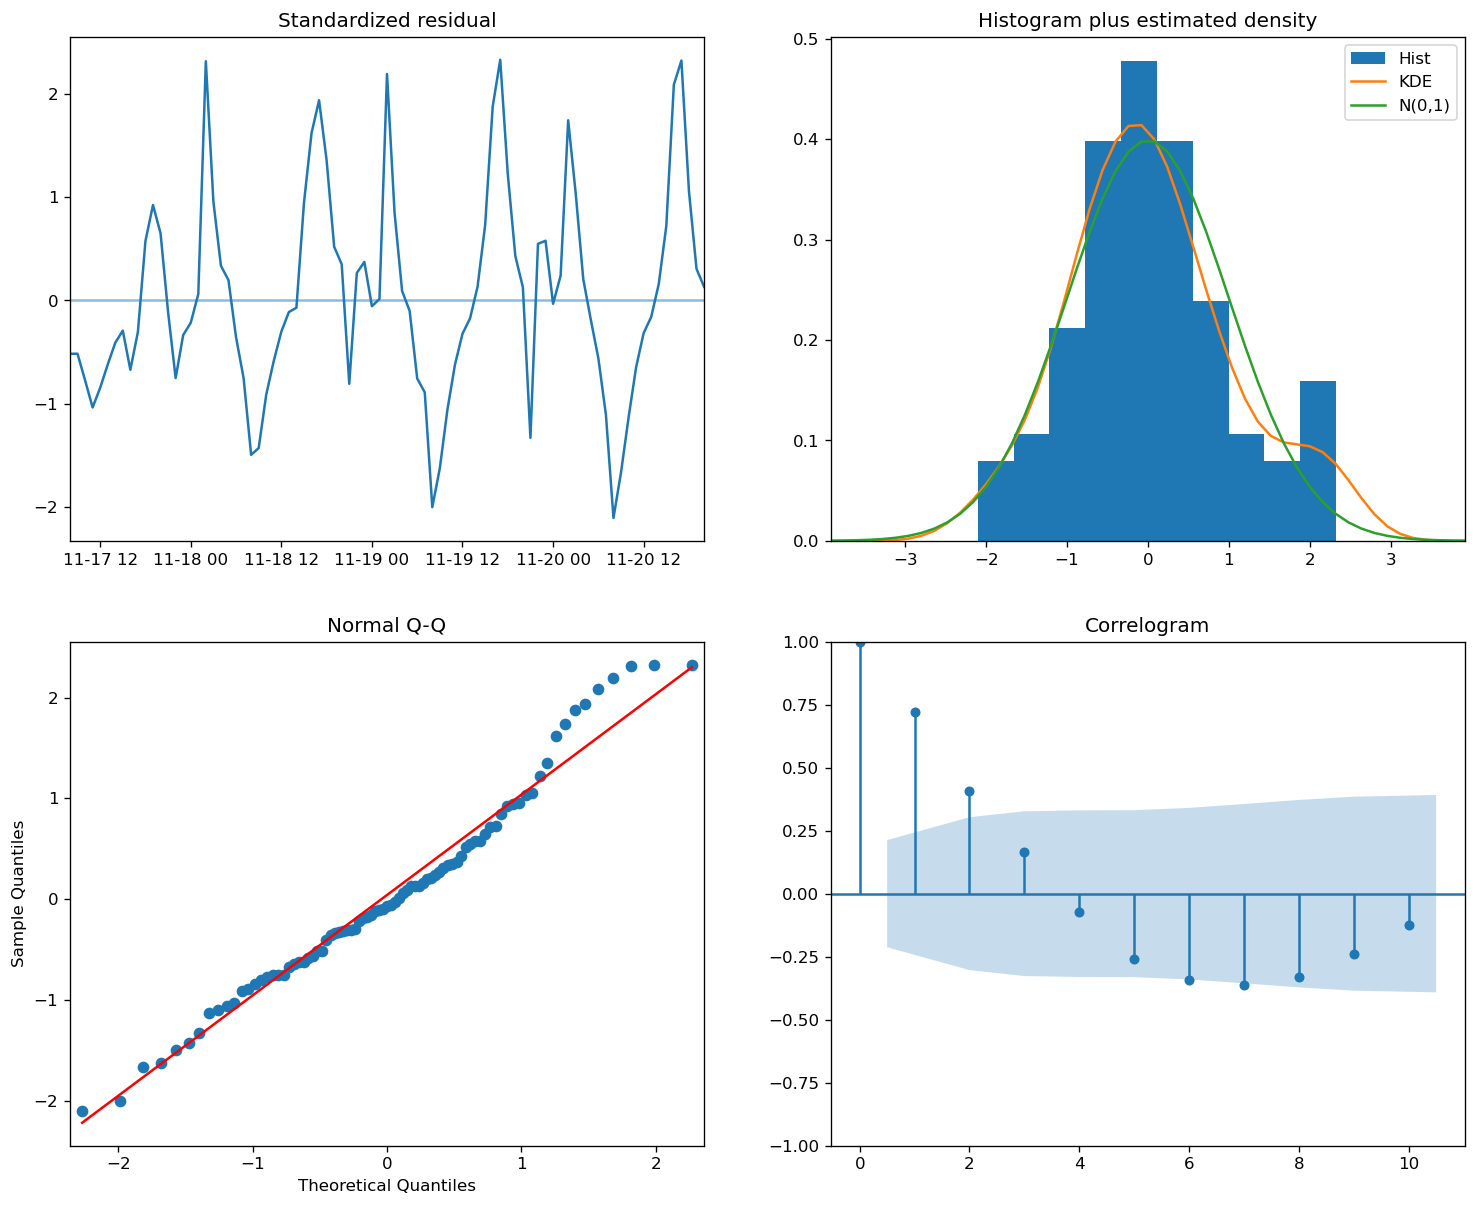

In [200]:
plot=AR.plot_diagnostics(figsize=(15, 12))

In [201]:
MA.fit(train)

MA.summary()

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -681.571
Date:                Sun, 24 Mar 2024   AIC                           1369.143
Time:                        19:13:49   BIC                           1376.471
Sample:                    11-17-2020   HQIC                          1372.090
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5730.4460    168.751     33.958      0.000    5399.701    6061.191
ma.L1          0.9993      0.563      1.774      0.076      -0.105       2.104
sigma2      5.164e+05   2.42e+05      2.137      0.033    4.27e+04     9.9e+05
===================================================================================
Ljung-Box (L1) (Q):                  34.34   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               1.46   Skew:                             0.40
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

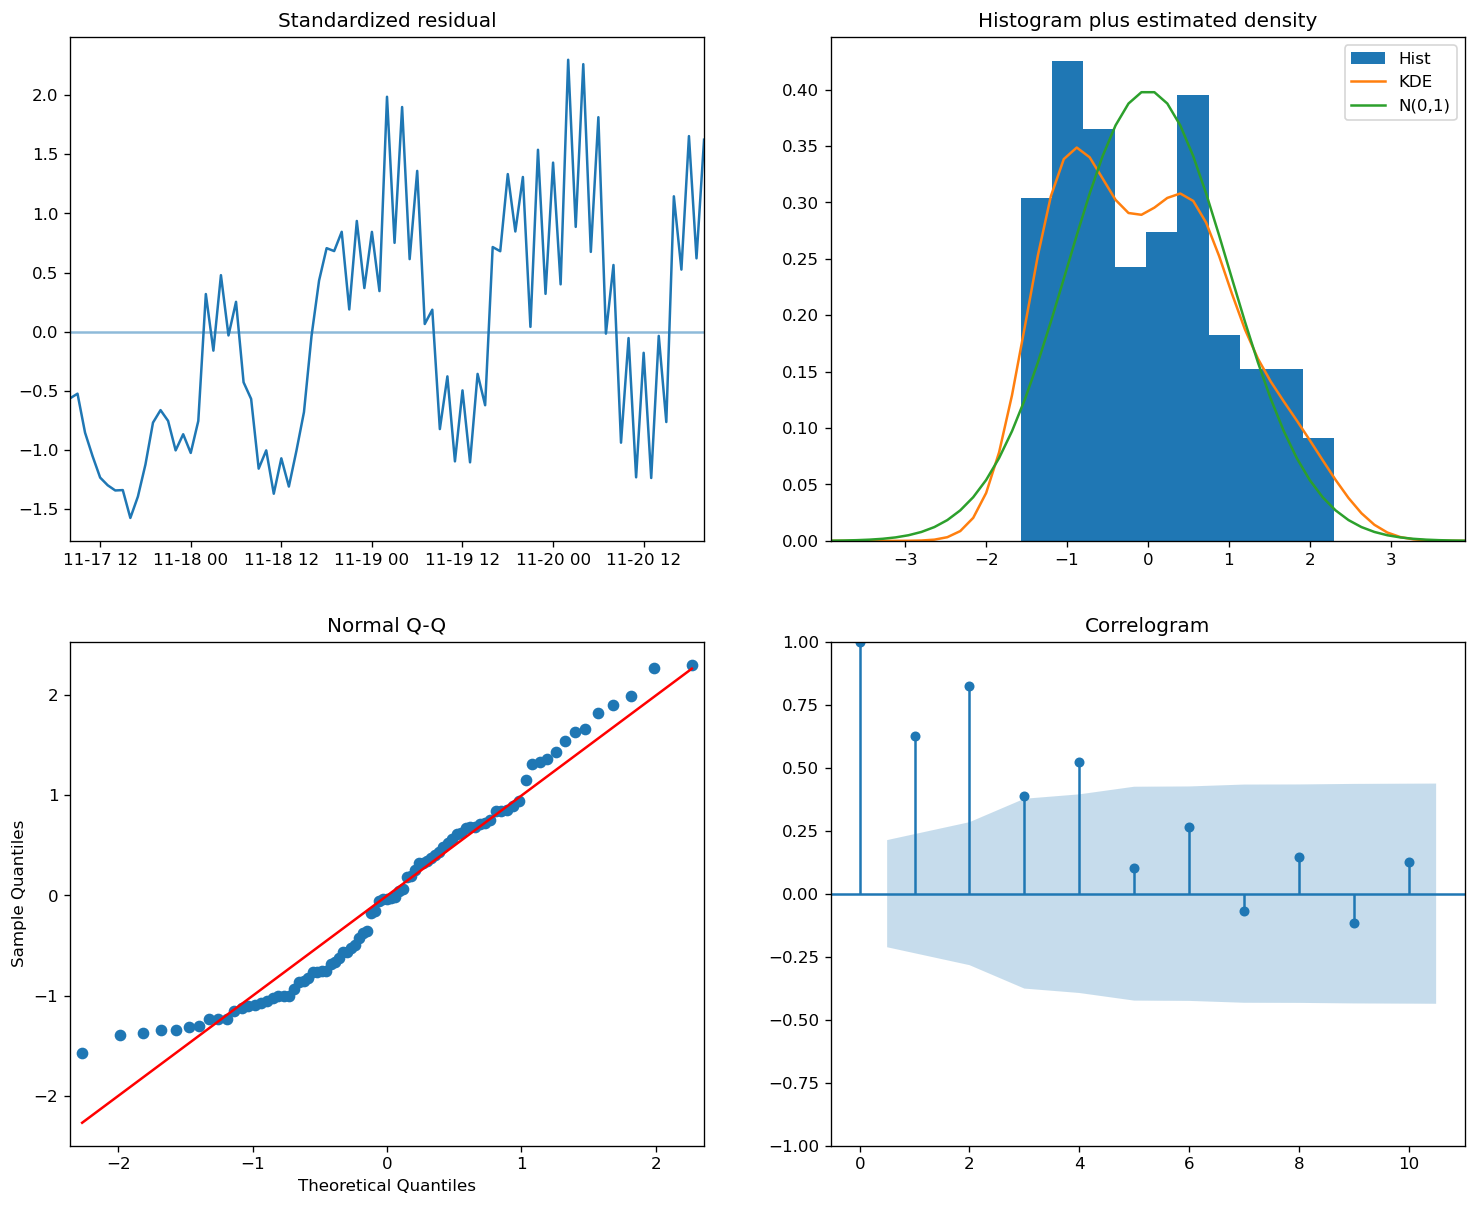

In [202]:
plot=MA.plot_diagnostics(figsize=(15, 12))

<AxesSubplot:title={'center':'Forecasting with AR'}, xlabel='datetime'>

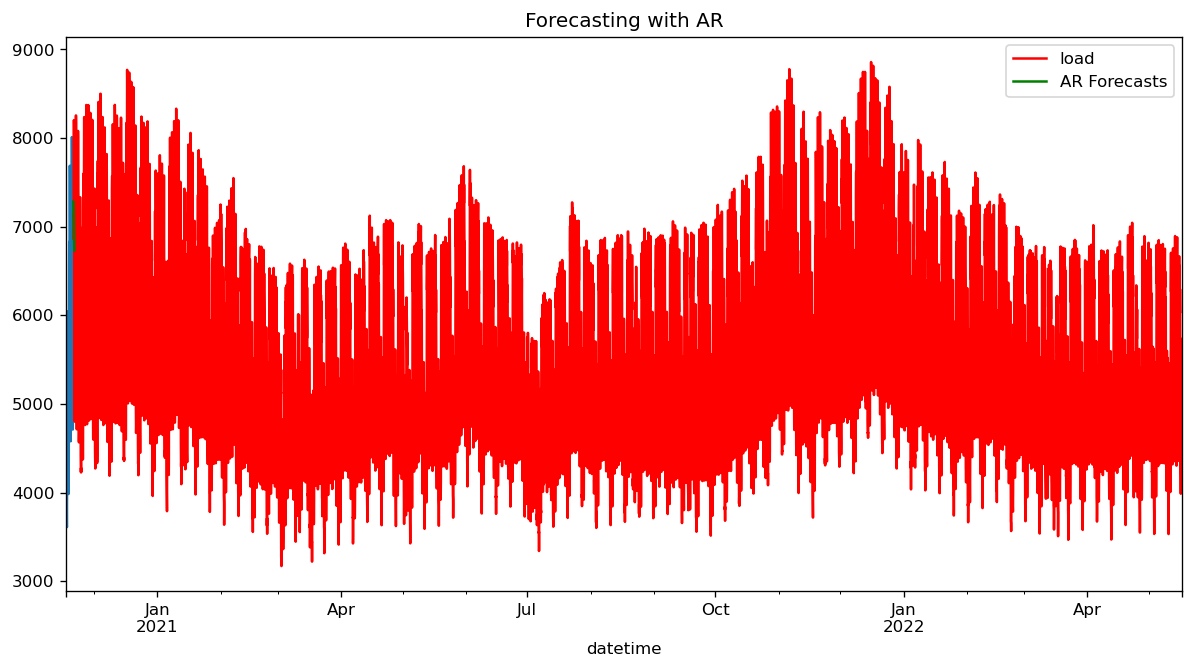

In [203]:
forecasts = AR.predict(12)
forecasts = pd.Series(forecasts, index=test.index).rename('AR Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with AR')
forecasts.plot(legend=True, color='green')

In [204]:
err = MASE(train, test, forecasts)

err

1.929075780155376

# Exponential Smoothing

In [205]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

ses_model_manual = SimpleExpSmoothing(train, initialization_method="heuristic").fit(smoothing_level=0.5, optimized=False)

ses_model_auto = SimpleExpSmoothing(train, initialization_method="estimated").fit()

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [206]:
ses_model_manual.summary()

Dep. Variable:,load,No. Observations:,85
Model:,SimpleExpSmoothing,SSE,34217822.959
Optimized:,False,AIC,1100.977
Trend:,None,BIC,1105.862
Seasonal:,None,AICC,1101.477
Seasonal Periods:,None,Date:,"Sun, 24 Mar 2024"
Box-Cox:,False,Time:,19:13:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,5199.6667,l.0,False


In [207]:
ses_model_auto.summary()

Dep. Variable:,load,No. Observations:,85
Model:,SimpleExpSmoothing,SSE,13513200.997
Optimized:,True,AIC,1022.005
Trend:,None,BIC,1026.890
Seasonal:,None,AICC,1022.505
Seasonal Periods:,None,Date:,"Sun, 24 Mar 2024"
Box-Cox:,False,Time:,19:13:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,5116.5417,l.0,True


In [208]:
ses_forecasts = ses_model_auto.forecast(12)

print(MASE(train,test,ses_forecasts))

1.6150421371725239


<AxesSubplot:title={'center':'Forecasting with SES'}, xlabel='datetime'>

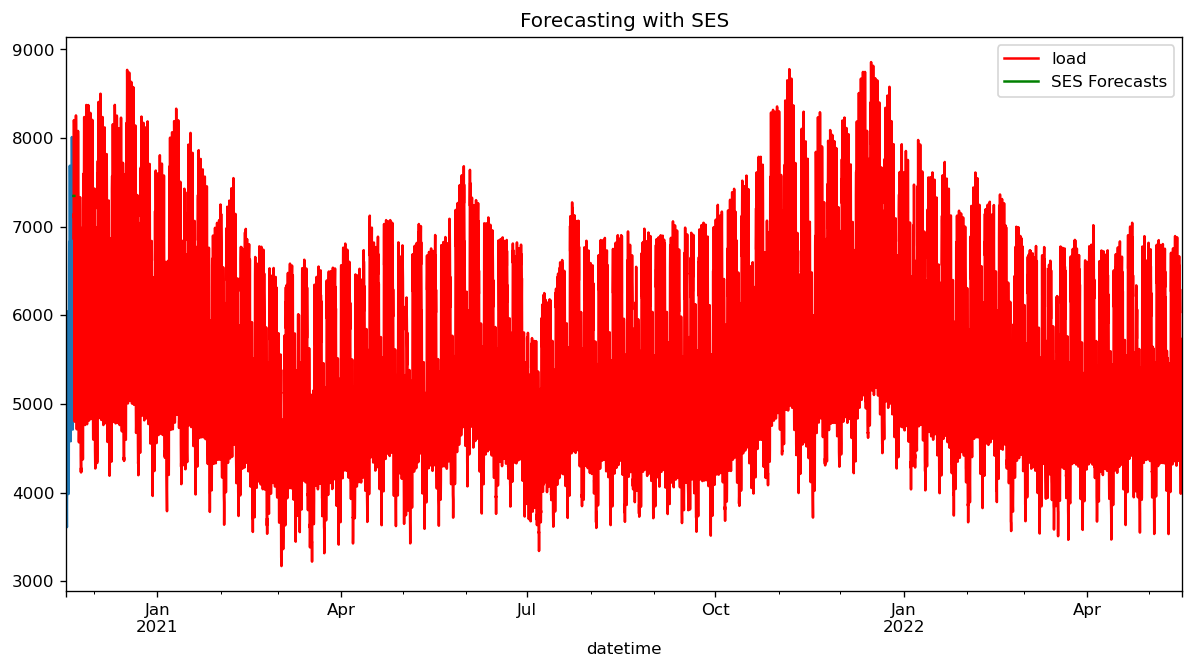

In [209]:
ses_forecasts = pd.Series(ses_forecasts, index=test.index).rename('SES Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with SES')
ses_forecasts.plot(legend=True, color='green')

In [210]:
import matplotlib.pyplot as plt

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


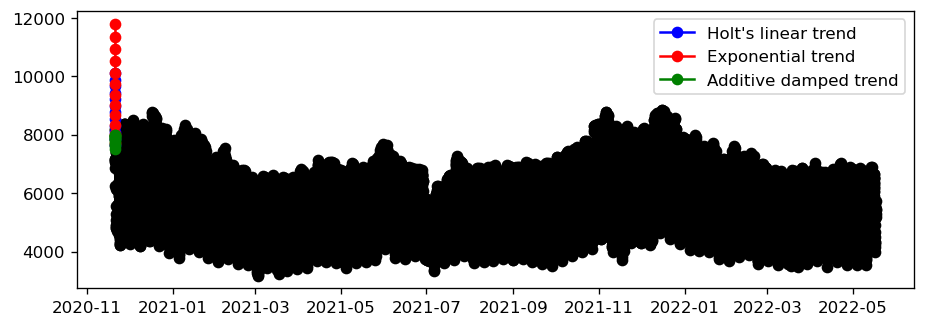

In [211]:
# HOLD
holt_model1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m1 = holt_model1.forecast(12).rename("Holt's linear trend")


holt_model2 = Holt(train, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
forecasts_holt_m2 = holt_model2.forecast(12).rename("Exponential trend")


holt_model3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
forecasts_holt_m3 = holt_model3.forecast(12).rename("Additive damped trend")


plt.figure()
plt.plot(test, marker="o", color="black")
(line1,) = plt.plot(forecasts_holt_m1, marker="o", color="blue")
(line2,) = plt.plot(forecasts_holt_m2, marker="o", color="red")
(line3,) = plt.plot(forecasts_holt_m3, marker="o", color="green")
plt.legend([line1, line2, line3], [forecasts_holt_m1.name, forecasts_holt_m2.name, forecasts_holt_m3.name])

In [226]:
# Holt’s Winters Seasonal Exponential Smoothing
es = ExponentialSmoothing(
    train,
    #seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=False,
    initialization_method="estimated",
).fit()

forecasts_es = es.forecast(12).rename("Holt’s Winters Seasonal Exponential Smoothing")

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


0.5761932001954696


<AxesSubplot:title={'center':'Forecasting with ES'}, xlabel='datetime'>

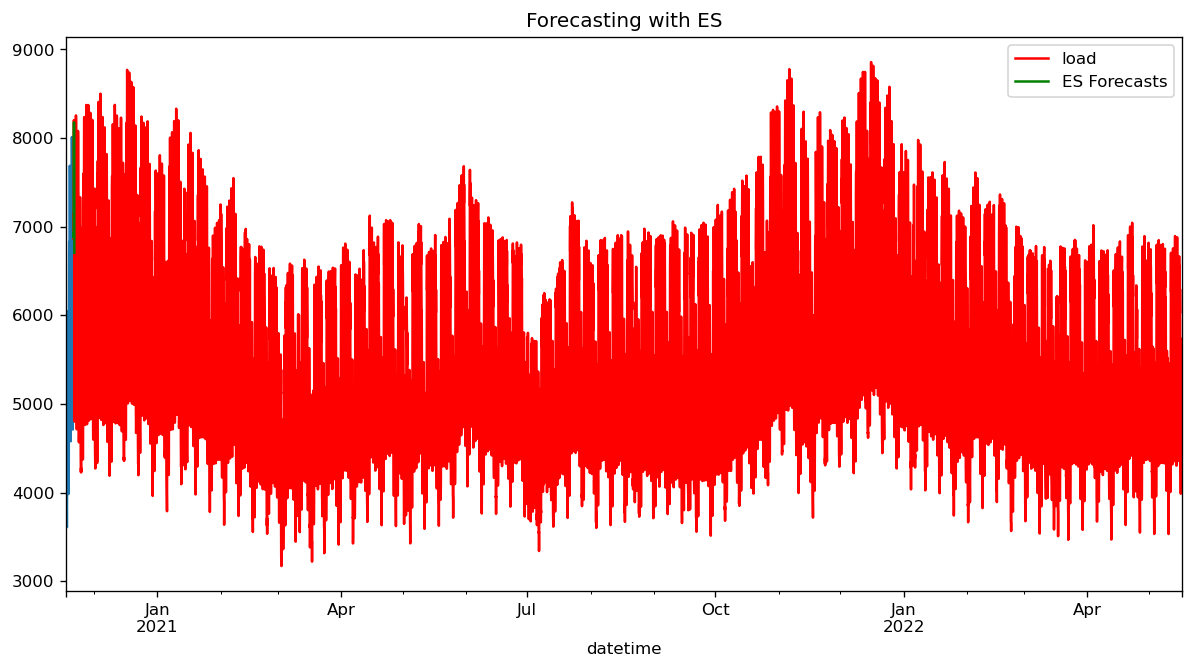

In [227]:
print(MASE(train,test,forecasts_es))

forecasts_es = forecasts_es.rename('ES Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with ES')
forecasts_es.plot(legend=True, color='green')

In [224]:
ets = ETSModel(
    train,
    #seasonal_periods=4,
    trend="mul",
    seasonal="mul",
    initialization_method="estimated",
).fit()

forecasts_ets = ets.forecast(12).rename("ETS")

/home/dcm/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15268D+00    |proj g|=  9.88789D-01

At iterate    1    f=  8.81118D+00    |proj g|=  2.12957D+00

At iterate    2    f=  8.05669D+00    |proj g|=  1.37120D+01

At iterate    3    f=  8.01486D+00    |proj g|=  9.68050D-01

At iterate    4    f=  7.99355D+00    |proj g|=  9.60864D-01

At iterate    5    f=  7.75053D+00    |proj g|=  1.26777D+01

At iterate    6    f=  7.60664D+00    |proj g|=  1.61474D+01
  ys=-1.572E-03  -gs= 1.479E-01 BFGS update SKIPPED

At iterate    7    f=  7.50619D+00    |proj g|=  2.31956D+00

At iterate    8    f=  7.25539D+00    |proj g|=  4.28130D+00

At iterate    9    f=  7.17538D+00    |proj g|=  1.83156D+00

At iterate   10    f=  6.90325D+00    |proj g|=  2.63031D+00
  ys=-5.033E-02  -gs= 2.429E-01 BFGS update SKIPPED

At iterate   11    f=  6.68263D+00    |proj g|


At iterate   13    f=  6.58381D+00    |proj g|=  6.18461D-01

At iterate   14    f=  6.57575D+00    |proj g|=  5.11957D-01

At iterate   15    f=  6.57108D+00    |proj g|=  5.15517D-01

At iterate   16    f=  6.56584D+00    |proj g|=  5.25202D-01

At iterate   17    f=  6.55951D+00    |proj g|=  5.25981D-01

At iterate   18    f=  6.55565D+00    |proj g|=  1.17358D+00

At iterate   19    f=  6.54759D+00    |proj g|=  4.81044D-01

At iterate   20    f=  6.54197D+00    |proj g|=  4.13476D-01

At iterate   21    f=  6.53475D+00    |proj g|=  5.72693D-01

At iterate   22    f=  6.52159D+00    |proj g|=  8.76150D-01

At iterate   23    f=  6.51688D+00    |proj g|=  9.67277D-01

At iterate   24    f=  6.50833D+00    |proj g|=  3.32151D-01

At iterate   25    f=  6.50555D+00    |proj g|=  3.59556D-01

At iterate   26    f=  6.49699D+00    |proj g|=  6.62896D-01

At iterate   27    f=  6.48443D+00    |proj g|=  7.77213D-01

At iterate   28    f=  6.47831D+00    |proj g|=  2.89034D+00

At iter

2.368740506980885


<AxesSubplot:title={'center':'Forecasting with ETS'}, xlabel='datetime'>

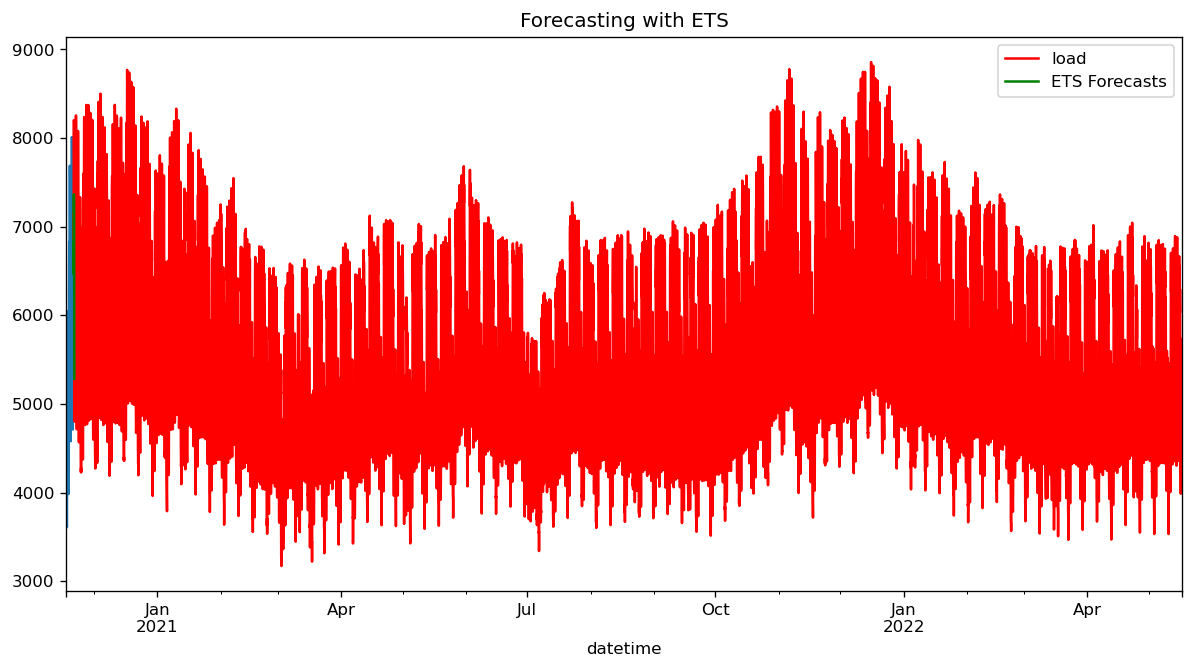

In [225]:
print(MASE(train,test,forecasts_ets))

forecasts_ets = forecasts_ets.rename('ETS Forecasts')
ax = train.plot()
ax = test.plot(legend=True,color='red', figsize=(12,6),title='Forecasting with ETS')
forecasts_ets.plot(legend=True, color='green')